In [1]:
from FinancialMachineLearning.generator.stochasticprocess import MonteCarloSimulation
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [2]:
class OptionPricing:
    def __init__(self, stock_price_paths: np.ndarray, interest_rate: float, maturity: float):
        self.stock_price_paths = stock_price_paths
        self.interest_rate = interest_rate
        self.maturity = maturity
        self.discount_factor = np.exp(-interest_rate * maturity)
        
        self.time_steps = stock_price_paths.shape[-1]
        self.dt = maturity / (self.time_steps - 1)
        self.discount_table = np.exp(-interest_rate * np.arange(self.time_steps) * self.dt)

    def european_call_option(self, exercise_price: float) -> np.ndarray:
        call_payoffs = np.maximum(self.stock_price_paths - exercise_price, 0)
        discounted_call_payoffs = call_payoffs * self.discount_factor
        return discounted_call_payoffs

    def european_put_option(self, exercise_price: float) -> np.ndarray:
        put_payoffs = np.maximum(exercise_price - self.stock_price_paths, 0)
        discounted_put_payoffs = put_payoffs * self.discount_factor
        return discounted_put_payoffs
    
    def asian_call_option(self, exercise_price: float, average_method : str = 'arithmetic') -> np.ndarray:
        if average_method == 'arithmetic' :
            average_price = self.stock_price_paths.mean(axis = 0)
        elif average_method == 'geometric' :
            average_price = ss.gmean(self.stock_price_paths, axis = 0)
        else : raise ValueError("avg_method must be either 'arithmetic' or 'geometric'")
        
        payoffs = np.maximum(average_price - exercise_price, 0)
        discounted_payoffs = payoffs * self.discount_factor
        
        return discounted_payoffs
    
    def asian_put_option(self, exercise_price: float, average_method : str = 'arithmetic') -> np.ndarray:
        if average_method == 'arithmetic' :
            average_price = self.stock_price_paths.mean(axis = 0)
        elif average_method == 'geometric' :
            average_price = ss.gmean(self.stock_price_paths, axis = 0)
        else : raise ValueError("avg_method must be either 'arithmetic' or 'geometric'")
        
        payoffs = np.maximum(exercise_price - average_price, 0)
        discounted_payoffs = payoffs * self.discount_factor
        
        return discounted_payoffs
    
    def american_call_option(self, exercise_price: float, poly_degree: int = 2) -> np.ndarray:
        """
        American call option pricing using Longstaff-Schwartz method.
        """
        payoffs = np.maximum(self.stock_price_paths - exercise_price, 0)
        cash_flows = np.copy(payoffs)
        
        for t in reversed(range(1, self.time_steps - 1)):
            in_the_money = self.stock_price_paths[:, t] > exercise_price
            if np.any(in_the_money):
                regression_x = self.stock_price_paths[in_the_money, t]
                regression_y = cash_flows[in_the_money, t + 1] * np.exp(-self.interest_rate * self.dt)
                if len(regression_x) > 0:
                    coefficients = np.polyfit(regression_x, regression_y, poly_degree)
                    continuation_values = np.polyval(coefficients, self.stock_price_paths[in_the_money, t])
                    exercise_decision = payoffs[in_the_money, t] > continuation_values
                    cash_flows[in_the_money, t] = np.where(exercise_decision, payoffs[in_the_money, t], cash_flows[in_the_money, t + 1] * np.exp(-self.interest_rate * self.dt))
                cash_flows[~in_the_money, t] = cash_flows[~in_the_money, t + 1] * np.exp(-self.interest_rate * self.dt)

        discounted_cash_flows = cash_flows * np.exp(-self.interest_rate * self.dt)
        return discounted_cash_flows

    def american_put_option(self, exercise_price: float, poly_degree: int = 2) -> np.ndarray:
        """
        American put option pricing using longstaff schwartz methods
        """
        payoffs = np.maximum(exercise_price - self.stock_price_paths, 0)
        cash_flows = np.copy(payoffs)  
    
        for t in reversed(range(1, self.time_steps - 1)):
            in_the_money = self.stock_price_paths[:, t] > exercise_price
            if np.any(in_the_money):
                regression_x = self.stock_price_paths[in_the_money, t]
                regression_y = cash_flows[in_the_money, t + 1] * np.exp(-self.interest_rate * self.dt)
                if len(regression_x) > 0:
                    coefficients = np.polyfit(regression_x, regression_y, poly_degree)
                    continuation_values = np.polyval(coefficients, self.stock_price_paths[in_the_money, t])
                    exercise_decision = payoffs[in_the_money, t] > continuation_values
                    cash_flows[in_the_money, t] = np.where(exercise_decision, payoffs[in_the_money, t], cash_flows[in_the_money, t + 1] * np.exp(-self.interest_rate * self.dt))
                cash_flows[~in_the_money, t] = cash_flows[~in_the_money, t + 1] * np.exp(-self.interest_rate * self.dt)

        discounted_cash_flows = cash_flows * np.exp(-self.interest_rate * self.dt)
        return discounted_cash_flows

In [3]:
simulation = MonteCarloSimulation(
    interest_rate = 0.05,    
    initial_price = 130,     
    maturity = 1,          
    sigma = 0.2,           
    dividend_yield = 0.02,  
    nObs = 10000,           
    slices = 252,       
    random_state = 42 
)

gbm = simulation.geometric_brownian_motion()

In [4]:
option_pricing = OptionPricing(gbm.T, interest_rate = 0.05, maturity = 1)

In [5]:
import warnings
warnings.filterwarnings('ignore')

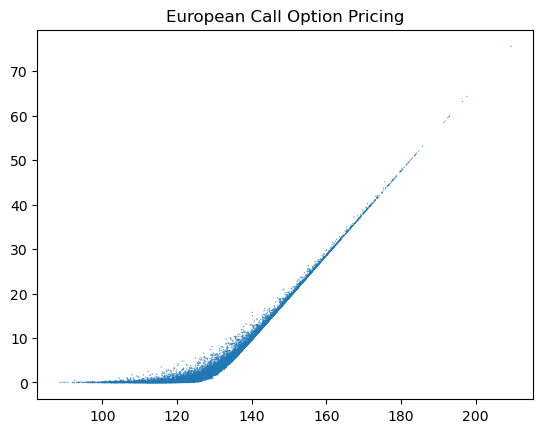

In [8]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.european_call_option(130).mean(axis = 0),
    marker = '.',
    s = 4,
    alpha = 0.7,
    edgecolor = 'none'
)
plt.title('European Call Option Pricing')
plt.show()

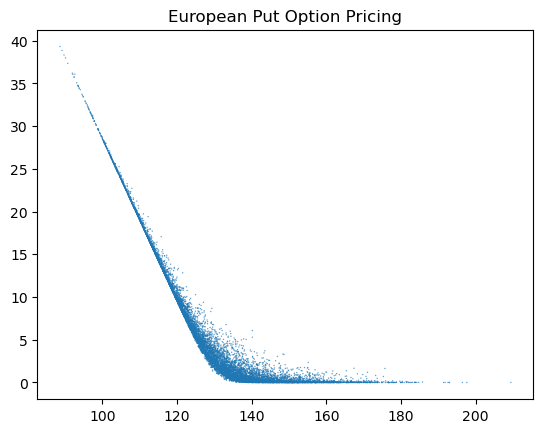

In [9]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.european_put_option(130).mean(axis = 0),
    marker = '.',
    s = 4,
    alpha = 0.7,
    edgecolor = 'none'
)
plt.title('European Put Option Pricing')
plt.show()

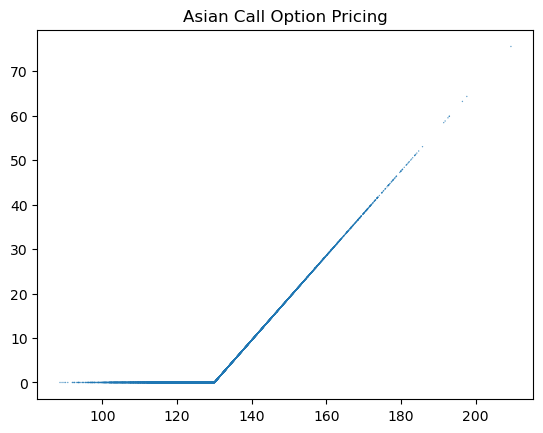

In [10]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.asian_call_option(130),
    marker = '.',
    s = 4,
    alpha = 0.7,
    edgecolor = 'none'
)
plt.title('Asian Call Option Pricing')
plt.show()

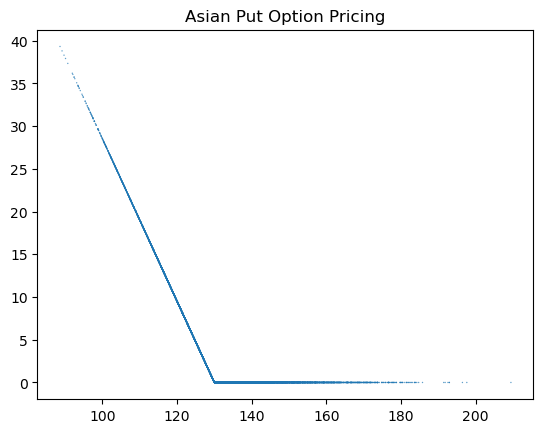

In [11]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.asian_put_option(130),
    marker = '.',
    s = 4,
    alpha = 0.7,
    edgecolor = 'none'
)
plt.title('Asian Put Option Pricing')
plt.show()

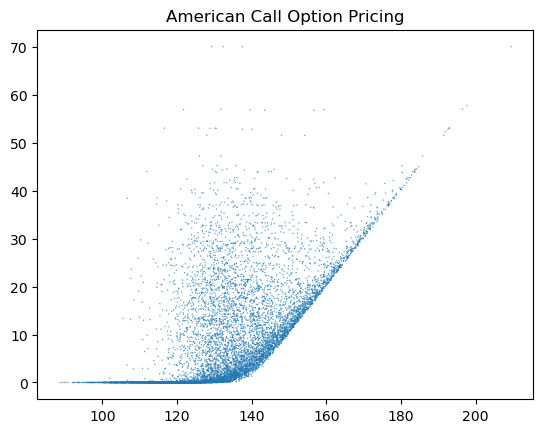

In [12]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.american_call_option(140).mean(axis = 0),
    marker = '.',
    s = 4,
    alpha = 0.7,
    edgecolor = 'none'
)
plt.title('American Call Option Pricing')
plt.show()

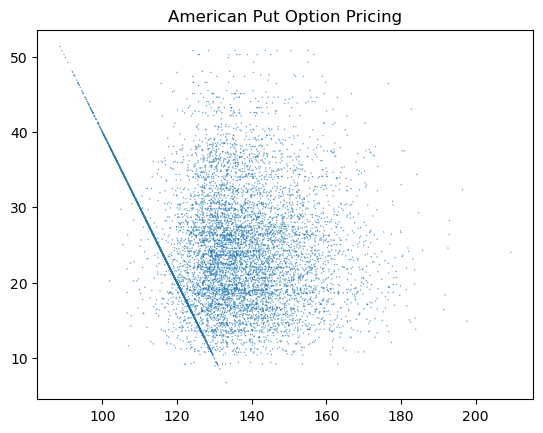

In [26]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.american_put_option(140).mean(axis = 0),
    marker = '.',
    s = 4,
    alpha = 0.7,
    edgecolor = 'none'
)
plt.title('American Put Option Pricing')
plt.show()

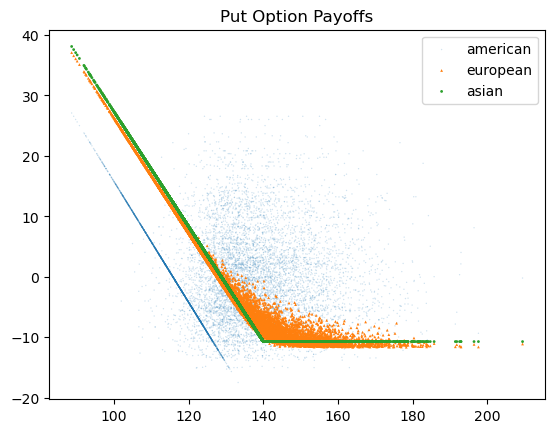

In [31]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.american_put_option(140).mean(axis = 0) - option_pricing.american_put_option(140).mean(axis = 0).mean(),
    marker = '.',
    s = 4,
    alpha = 0.2,
    edgecolor = 'none',
    label = 'american'
)
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.european_put_option(140).mean(axis = 0) - option_pricing.european_put_option(140).mean(axis = 0).mean(),
    marker = '^',
    s = 4,
    alpha = 1,
    edgecolor = 'none',
    label = 'european'
)
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.asian_put_option(140) - option_pricing.asian_put_option(140).mean(),
    marker = 'o',
    s = 4,
    alpha = 1,
    edgecolor = 'none',
    label = 'asian'
)
plt.legend()
plt.title('Put Option Payoffs')
plt.show()

In [34]:
print(f'expected american put option premium : {option_pricing.american_put_option(140).mean(axis = 0).mean() : .2f}')
print(f'expected european put option premium : {option_pricing.european_put_option(140).mean(axis = 0).mean() : .2f}')
print(f'expected asian put option premium : {option_pricing.asian_put_option(140).mean() : .2f}')

expected american put option premium :  24.23
expected european put option premium :  11.73
expected asian put option premium :  10.72


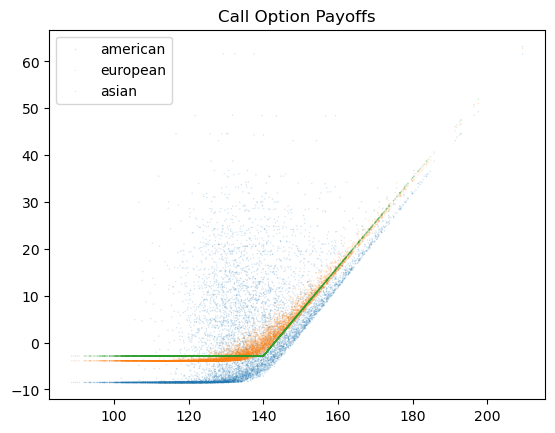

In [30]:
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.american_call_option(140).mean(axis = 0) - option_pricing.american_call_option(140).mean(axis = 0).mean(),
    marker = '.',
    s = 4,
    alpha = 0.2,
    edgecolor = 'none',
    label = 'american'
)
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.european_call_option(140).mean(axis = 0) - option_pricing.european_call_option(140).mean(axis = 0).mean(),
    marker = '.',
    s = 4,
    alpha = 0.2,
    edgecolor = 'none',
    label = 'european'
)
plt.scatter(
    gbm.T.mean(axis = 0),
    option_pricing.asian_call_option(140) - option_pricing.asian_call_option(140).mean(),
    marker = '.',
    s = 4,
    alpha = 0.2,
    edgecolor = 'none',
    label = 'asian'
)
plt.legend()
plt.title('Call Option Payoffs')
plt.show()

In [35]:
print(f'expected american call option premium : {option_pricing.american_call_option(140).mean(axis = 0).mean() : .2f}')
print(f'expected european call option premium : {option_pricing.european_call_option(140).mean(axis = 0).mean() : .2f}')
print(f'expected asian call option premium : {option_pricing.asian_call_option(140).mean() : .2f}')

expected american call option premium :  8.50
expected european call option premium :  3.87
expected asian call option premium :  2.86


In [ ]:
class OptionPricing :
    def __init__(self, initial_price : float, price: np.ndarray, exercise_price : float, interest_rate: float, maturity: float, sigma: float,
                 dividend_yield: float, random_state: bool or int = False):
        self.price_array = price
        self.T = float(maturity)
        self.dividend_yield = float(dividend_yield)
        self.slices = price.shape[1]
        self.nObs = price.shape[0]
        self.dt = self.T / self.slices
        self.mu = interest_rate
        self.r = np.full((self.nObs, self.slices), interest_rate * self.dt)
        self.discount_table = np.exp(np.cumsum(-self.r, axis=1))
        self.sigma = np.full((self.nObs, self.slices), sigma)
        self.terminal_prices = []
        self.z_t = np.random.standard_normal((self.nObs, self.slices))

        if type(random_state) is bool:
            if random_state: np.random.seed(0)
        elif type(random_state) is int:
            np.random.seed(random_state
                           )
    def european_call(self):
        assert len(self.terminal_prices) != 0, 'Please simulate the stock price first'

        self.terminal_profit = np.maximum((self.terminal_prices - self.K), 0.0)

        self.expectation = np.average(self.terminal_profit * np.exp(-np.sum(self.r, axis=1)))

        print('-' * 64)
        print(
            " European call monte carlo \n S0 %4.1f \n K %2.1f \n"
            " Call Option Value %4.3f \n " % (
                self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)

        return self.expectation

    def european_put(self, empirical_call: float or None = None) -> float:
        """
        Use put call parity (incl. continuous dividend) to calculate the put option value
        :param empirical_call: can be calculated or observed call option value
        :return: put option value
        """
        if empirical_call is not None:
            self.european_call_value = self.european_call()
        else:
            self.european_call_value = empirical_call

        self.put_value = self.european_call_value + np.exp(-np.sum(self.r, axis=1)) * self.K - np.exp(
            -self.div_yield * self.T) * self.S0

        return self.put_value

    def asian_avg_price_option(self, avg_method: str = 'arithmetic', option_type: str = 'call') -> float:
        assert option_type == 'call' or option_type == 'put', 'option_type must be either call or put'
        assert len(self.terminal_prices) != 0, 'Please simulate the stock price first'
        assert avg_method == 'arithmetic' or avg_method == 'geometric', 'arithmetic or geometric average?'

        average_prices = np.average(self.price_array, axis=1)

        if option_type == 'call':
            self.terminal_profit = np.maximum((average_prices - self.K), 0.0)
        elif option_type == 'put':
            self.terminal_profit = np.maximum((self.K - average_prices), 0.0)

        if avg_method == 'arithmetic':
            self.expectation = np.average(self.terminal_profit * np.exp(-np.sum(self.r, axis=1)))
        elif avg_method == 'geometric':
            self.expectation = sts.gmean(self.terminal_profit * np.exp(-np.sum(self.r, axis=1)))

        self.standard_error = np.std(self.terminal_profit) / np.sqrt(len(self.terminal_profit))

        print('-' * 64)
        print(
            " Asian %s monte carlo arithmetic average \n S0 %4.1f \n K %2.1f \n"
            " Option Value %4.3f" % (
                option_type, self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)

        return self.expectation

    def american_option_longstaff_schwartz(self, poly_degree: int = 2, option_type: str = 'call') -> float:
        """
        American option, Longstaff and Schwartz method

        :param poly_degree: x^n, default = 2
        :param option_type: call or put
        """
        assert option_type == 'call' or option_type == 'put', 'option_type must be either call or put'
        assert len(self.terminal_prices) != 0, 'Please simulate the stock price first'

        if option_type == 'call':
            self.intrinsic_val = np.maximum((self.price_array - self.K), 0.0)
        elif option_type == 'put':
            self.intrinsic_val = np.maximum((self.K - self.price_array), 0.0)

        # last day cashflow == last day intrinsic value
        cf = self.intrinsic_val[:, -1]

        stopping_rule = np.zeros_like(self.price_array)
        stopping_rule[:, -1] = np.where(self.intrinsic_val[:, -1] > 0, 1, 0)

        # Longstaff and Schwartz iteration
        for t in range(self.no_of_slices - 2, 0, -1):  # fill out the value table from backwards
            # find out in-the-money path to better estimate the conditional expectation function
            # where exercise is relevant and significantly improves the efficiency of the algorithm
            itm_path = np.where(self.intrinsic_val[:, t] > 0)  # <==> self.price_array[:, t] vs. self.K

            cf = cf * np.exp(-self.r[:, t + 1])
            Y = cf[itm_path]
            X = self.price_array[itm_path, t]

            # initialize continuation value
            hold_val = np.zeros(shape=self.simulation_rounds)
            # if there is only 5 in-the-money paths (most likely appear in out-of-the-money options
            # then simply assume that value of holding = 0.
            # otherwise, run regression and compute conditional expectation E[Y|X].
            if len(itm_path) > 5:
                rg = np.polyfit(x=X[0], y=Y, deg=poly_degree)  # regression fitting
                hold_val[itm_path] = np.polyval(p=rg, x=X[0])  # conditional expectation E[Y|X]

            # 1 <==> exercise, 0 <==> hold
            stopping_rule[:, t] = np.where(self.intrinsic_val[:, t] > hold_val, 1, 0)
            # if exercise @ t, all future stopping rules = 0 as the option contract is exercised.
            stopping_rule[np.where(self.intrinsic_val[:, t] > hold_val), (t + 1):] = 0

            # cashflow @ t, if hold, cf = 0, if exercise, cf = intrinsic value @ t.
            cf = np.where(self.intrinsic_val[:, t] > 0, self.intrinsic_val[:, t], 0)

        simulation_vals = (self.intrinsic_val * stopping_rule * self.discount_table).sum(axis=1)
        self.expectation = np.average(simulation_vals)

        print('-' * 64)
        print(
            " American %s Longstaff-Schwartz method (assume polynomial fit)"
            " \n polynomial degree = %i \n S0 %4.1f \n K %2.1f \n"
            " Option Value %4.3f " % (
                option_type, poly_degree, self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)

        return self.expectation

    def barrier_option(self, option_type: str, barrier_price: float, barrier_type: str, barrier_direction: str,
                       parisian_barrier_days: int or None = None) -> float:
        assert option_type == "call" or option_type == "put", 'option type must be either call or put'
        assert barrier_type == "knock-in" or barrier_type == "knock-out", \
            'barrier type must be either knock-in or knock-out'
        assert barrier_direction == "up" or barrier_direction == "down", \
            'barrier direction must be either up or down'
        if barrier_direction == "up":
            barrier_check = np.where(self.price_array >= barrier_price, 1, 0)

            if parisian_barrier_days is not None:
                days_to_slices = int(parisian_barrier_days * self.no_of_slices / (self.T * 252))
                parisian_barrier_check = np.zeros((self.simulation_rounds, self.no_of_slices - days_to_slices))
                for i in range(0, self.no_of_slices - days_to_slices):
                    parisian_barrier_check[:, i] = np.where(
                        np.sum(barrier_check[:, i:i + days_to_slices], axis=1) >= parisian_barrier_days, 1, 0
                    )

                barrier_check = parisian_barrier_check

        elif barrier_direction == "down":
            barrier_check = np.where(self.price_array <= barrier_price, 1, 0)

            if parisian_barrier_days is not None:
                days_to_slices = int(parisian_barrier_days * self.no_of_slices / (self.T * 252))
                parisian_barrier_check = np.zeros((self.simulation_rounds, self.no_of_slices - days_to_slices))
                for i in range(0, self.no_of_slices - days_to_slices):
                    parisian_barrier_check[:, i] = np.where(
                        np.sum(barrier_check[:, i:i + days_to_slices], axis=1) >= parisian_barrier_days, 1, 0
                    )

                barrier_check = parisian_barrier_check

        if option_type == 'call':
            self.intrinsic_val = np.maximum((self.price_array - self.K), 0.0)
        elif option_type == 'put':
            self.intrinsic_val = np.maximum((self.K - self.price_array), 0.0)

        if barrier_type == "knock-in":
            self.terminal_profit = np.where(np.sum(barrier_check, axis=1) >= 1, self.intrinsic_val[:, -1], 0)
        elif barrier_type == "knock-out":
            self.terminal_profit = np.where(np.sum(barrier_check, axis=1) >= 1, 0, self.intrinsic_val[:, -1])

        self.expectation = np.average(self.terminal_profit * np.exp(-np.sum(self.r, axis=1)))

        print('-' * 64)
        print(
            " Barrier european %s \n Type: %s \n Direction: %s @ %s \n S0 %4.1f \n K %2.1f \n"
            " Option Value %4.3f" % (
                option_type, barrier_type, barrier_direction, barrier_price,
                self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)

        return self.expectation

    def look_back_european(self, option_type: str = 'call') -> float:
        assert len(self.terminal_prices) != 0, 'Please simulate the stock price first'
        assert option_type == 'call' or option_type == 'put', 'option_type must be either call or put'

        self.max_price = np.max(self.price_array, axis=1)
        self.min_price = np.min(self.price_array, axis=1)

        if option_type == "call":
            self.terminal_profit = np.maximum((self.max_price - self.K), 0.0)
        elif option_type == "put":
            self.terminal_profit = np.maximum((self.K - self.min_price), 0.0)

        self.expectation = np.average(self.terminal_profit * np.exp(-np.sum(self.r, axis=1)))
        self.standard_error = np.std(self.terminal_profit) / np.sqrt(len(self.terminal_profit))

        print('-' * 64)
        print(
            " Lookback european %s monte carlo \n S0 %4.1f \n K %2.1f \n"
            " Option Value %4.3f " % (
                option_type, self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)
        return self.expectation